# Quora Spam Detection Project

In [167]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D,Flatten, Bidirectional, Activation, Dropout, GlobalAveragePooling1D, SpatialDropout1D, LSTM, Conv1D, MaxPooling1D, Embedding, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, average_precision_score, balanced_accuracy_score, log_loss, matthews_corrcoef, cohen_kappa_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pylab import rcParams
import re
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from datetime import datetime
import contractions
import emoji
from keras.layers import GRU
from sklearn.utils import resample
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from collections import Counter
from nltk.util import ngrams
from wordcloud import WordCloud


import os
import sys

%matplotlib inline
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 10, 10


In [73]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Available devices:")
print(tf.config.list_physical_devices())

# Specifically check for GPU availability using the updated method
print("GPUs available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.13.0
Available devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [74]:
glove_file = r'glove.840B.300d.txt'
embedding_dim = 300
validation_split =0.05

In [75]:
data = pd.read_csv(r'train.csv')

## EDA

In [76]:
data

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
...,...,...,...
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0


In [77]:
data['question_text'][1]

'Do you have an adopted dog, how would you encourage people to adopt and not shop?'

* Dropping qid as it won't be necessary for prediction

In [78]:
data.drop(['qid'], axis=1, inplace=True)

In [79]:
data

,question_text,target
0,How did Quebec nationalists see their province...,0
1,"Do you have an adopted dog, how would you enco...",0
2,Why does velocity affect time? Does velocity a...,0
3,How did Otto von Guericke used the Magdeburg h...,0
4,Can I convert montra helicon D to a mountain b...,0
...,...,...
1306117,What other technical skills do you need as a c...,0
1306118,Does MS in ECE have good job prospects in USA ...,0
1306119,Is foam insulation toxic?,0
1306120,How can one start a research project based on ...,0


In [80]:
data[data["target"] == 1].shape

(80810, 2)

In [81]:
data[data["target"] == 0].shape

(1225312, 2)

In [82]:
data.shape

(1306122, 2)

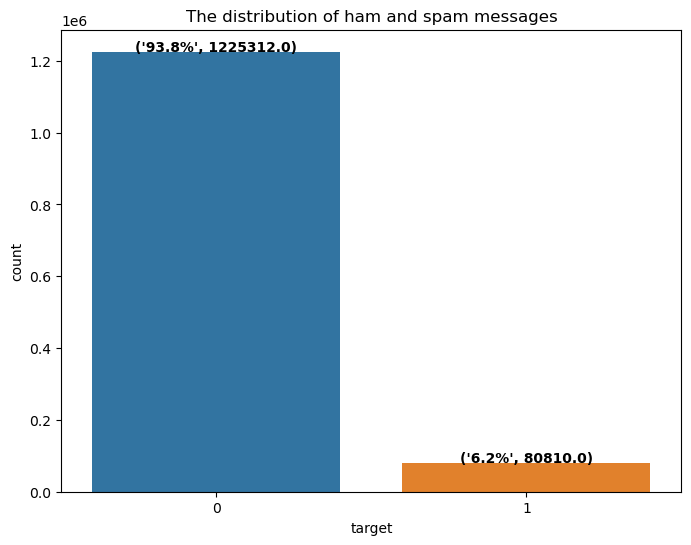

In [131]:
fig = plt.figure(figsize=(8,6))
ax = plt.axes()

plt.title('The distribution of ham and spam messages')
a=sns.countplot(data=data,x='target')
total=float(len(data))
bars_plot=ax.patches

for bars in bars_plot:
    percentage = '{:.1f}%'.format(100 * bars.get_height()/total)
    x = bars.get_x() + bars.get_width()/2.0
    y = bars.get_height()
    ax.text(x, y,(percentage,bars.get_height()),ha='center',fontweight='bold',fontsize=10)

* High Class Imbalance wherein spam class consists of 6% of the data set only. We have to use class weight for the model.

In [134]:
# Copying data set for EDA purpose
df_train1 = data.copy()

In [135]:
def length(text):
    length = len(text.split(" "))
    return(length)

df_train1['length'] = df_train1['question_text'].apply(length)
df_train1.head()

,question_text,target,length
0,How did Quebec nationalists see their province...,0,13
1,"Do you have an adopted dog, how would you enco...",0,16
2,Why does velocity affect time? Does velocity a...,0,10
3,How did Otto von Guericke used the Magdeburg h...,0,9
4,Can I convert montra helicon D to a mountain b...,0,15


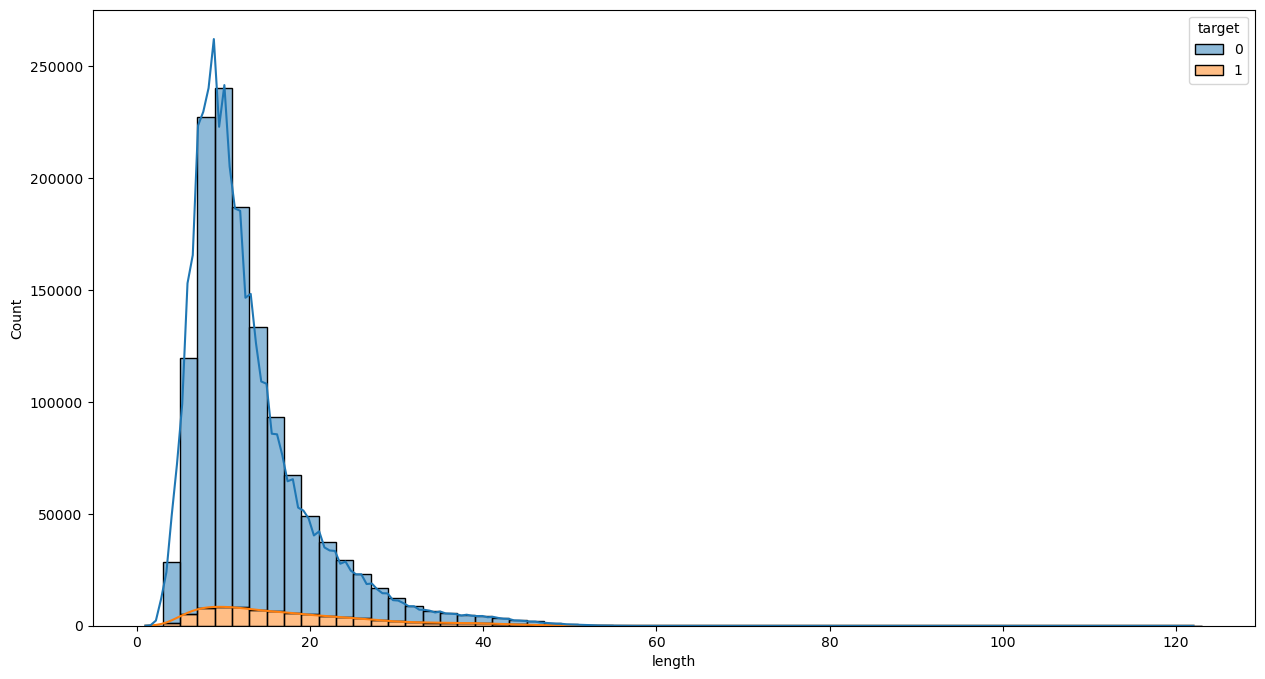

In [139]:
fig = plt.figure(figsize=(15,8))
a=sns.histplot(data=df_train1,x='length',hue='target',kde=True,binwidth=2,multiple='stack')


In [141]:
def remove_stopwords(text):
    text = str(text).lower()
    text = text.split(" ")
    lemma = WordNetLemmatizer()
    text = [lemma.lemmatize(i) for i in text if i not in set(stopwords.words('english'))]
    text = " ".join(text)
    return(text)
    

df_train1['question_text'] = df_train1['question_text'].apply(remove_stopwords)

In [142]:
df_train_sin = df_train1.loc[df_train1['target']==0]
df_train_insin = df_train1.loc[df_train1['target']==1]

In [143]:
df_train_sin.head()

,question_text,target,length
0,quebec nationalist see province nation 1960s?,0,13
1,"adopted dog, would encourage people adopt shop?",0,16
2,velocity affect time? velocity affect space ge...,0,10
3,otto von guericke used magdeburg hemispheres?,0,9
4,convert montra helicon mountain bike changing ...,0,15


In [144]:
df_train_insin.head()

,question_text,target,length
22,united state become largest dictatorship world?,1,11
30,baby sweeter parents? dark skin baby light ski...,1,15
110,black support school choice mandatory sentenci...,1,15
114,"gay boy love cousin (boy). sexy, dont know do....",1,34
115,race smallest penis?,1,6


In [154]:
def get_count(dataframe):
    words = dataframe['question_text'].str.split(expand=True).stack()
    return Counter(words).most_common()

In [155]:
# Function to get the top N words and their counts
def get_top_words(dic, top_n=50):
    top_words = [word for word, count in dic[:top_n]]
    top_counts = [count for word, count in dic[:top_n]]
    return top_words, top_counts

In [156]:
# Function to create bar plots for top words
def plot_top_words(top_words, top_counts, title, ax):
    sns.barplot(y=top_words, x=top_counts, ax=ax)
    ax.set_title(title)

In [157]:
dic_sin = get_count(df_train_sin)
dic_insin = get_count(df_train_insin)

In [158]:
dic_sin_top, dic_sin_topcount = get_top_words(dic_sin)
dic_insin_top, dic_insin_topcount = get_top_words(dic_insin)

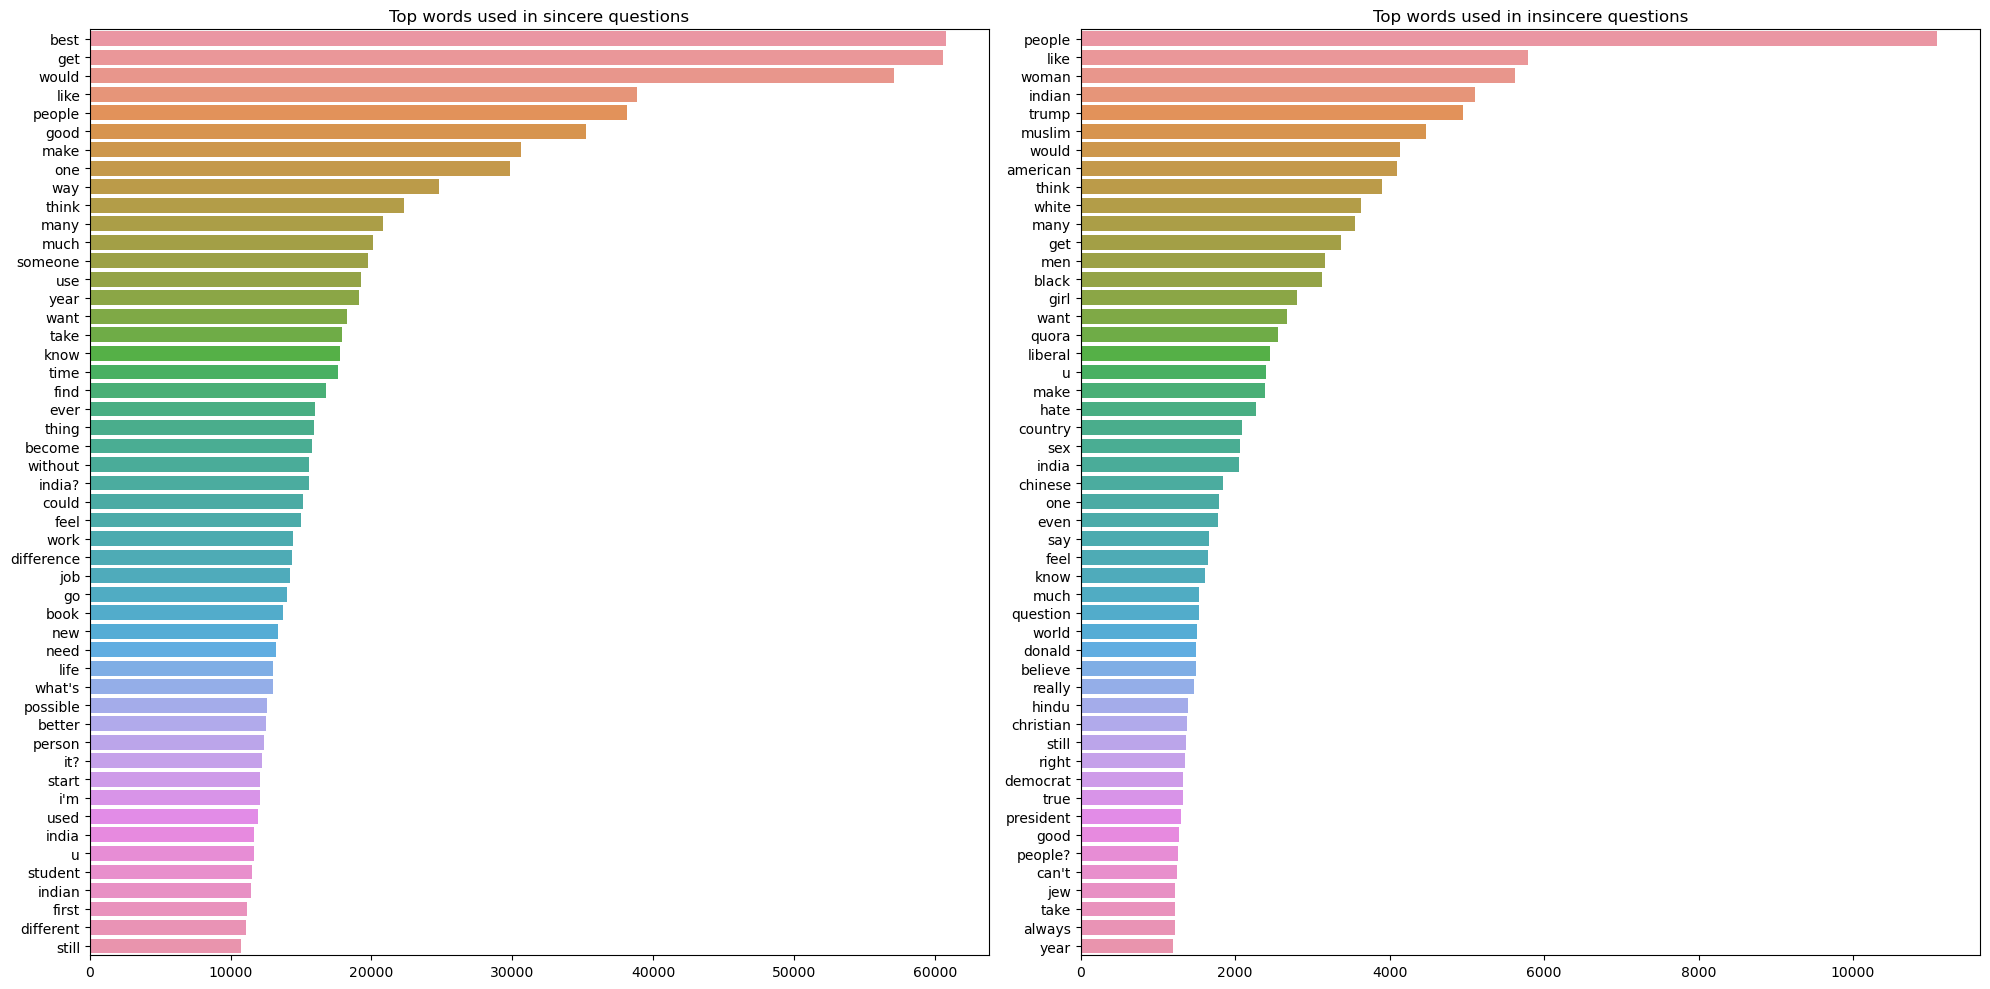

In [159]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
plot_top_words(dic_sin_top, dic_sin_topcount, "Top words used in sincere questions", ax[0])
plot_top_words(dic_insin_top, dic_insin_topcount, "Top words used in insincere questions", ax[1])
plt.tight_layout()
plt.show()

In [161]:
def get_bigrams(dataframe):
    all_bigrams = []
    for text in dataframe['question_text']:
        bigrams = ngrams(text.split(), 2)
        all_bigrams.extend(bigrams)
    return Counter(all_bigrams).most_common()

In [162]:
# Function to get the top N bigrams and their counts
def get_top_bigrams(dic, top_n=50):
    top_bigrams = [' '.join(bigram) for bigram, count in dic[:top_n]]
    top_counts = [count for bigram, count in dic[:top_n]]
    return top_bigrams, top_counts

In [163]:
# Function to create bar plots for top bigrams
def plot_top_bigrams(top_bigrams, top_counts, title, ax):
    sns.barplot(y=top_bigrams, x=top_counts, ax=ax)
    ax.set_title(title)

In [164]:
dic_sin_bigrams = get_bigrams(df_train_sin)
dic_insin_bigrams = get_bigrams(df_train_insin)

In [165]:
dic_sin_topbigrams, dic_sin_topcountbigrams = get_top_bigrams(dic_sin_bigrams)
dic_insin_topbigrams, dic_insin_topcountbigrams = get_top_bigrams(dic_insin_bigrams)

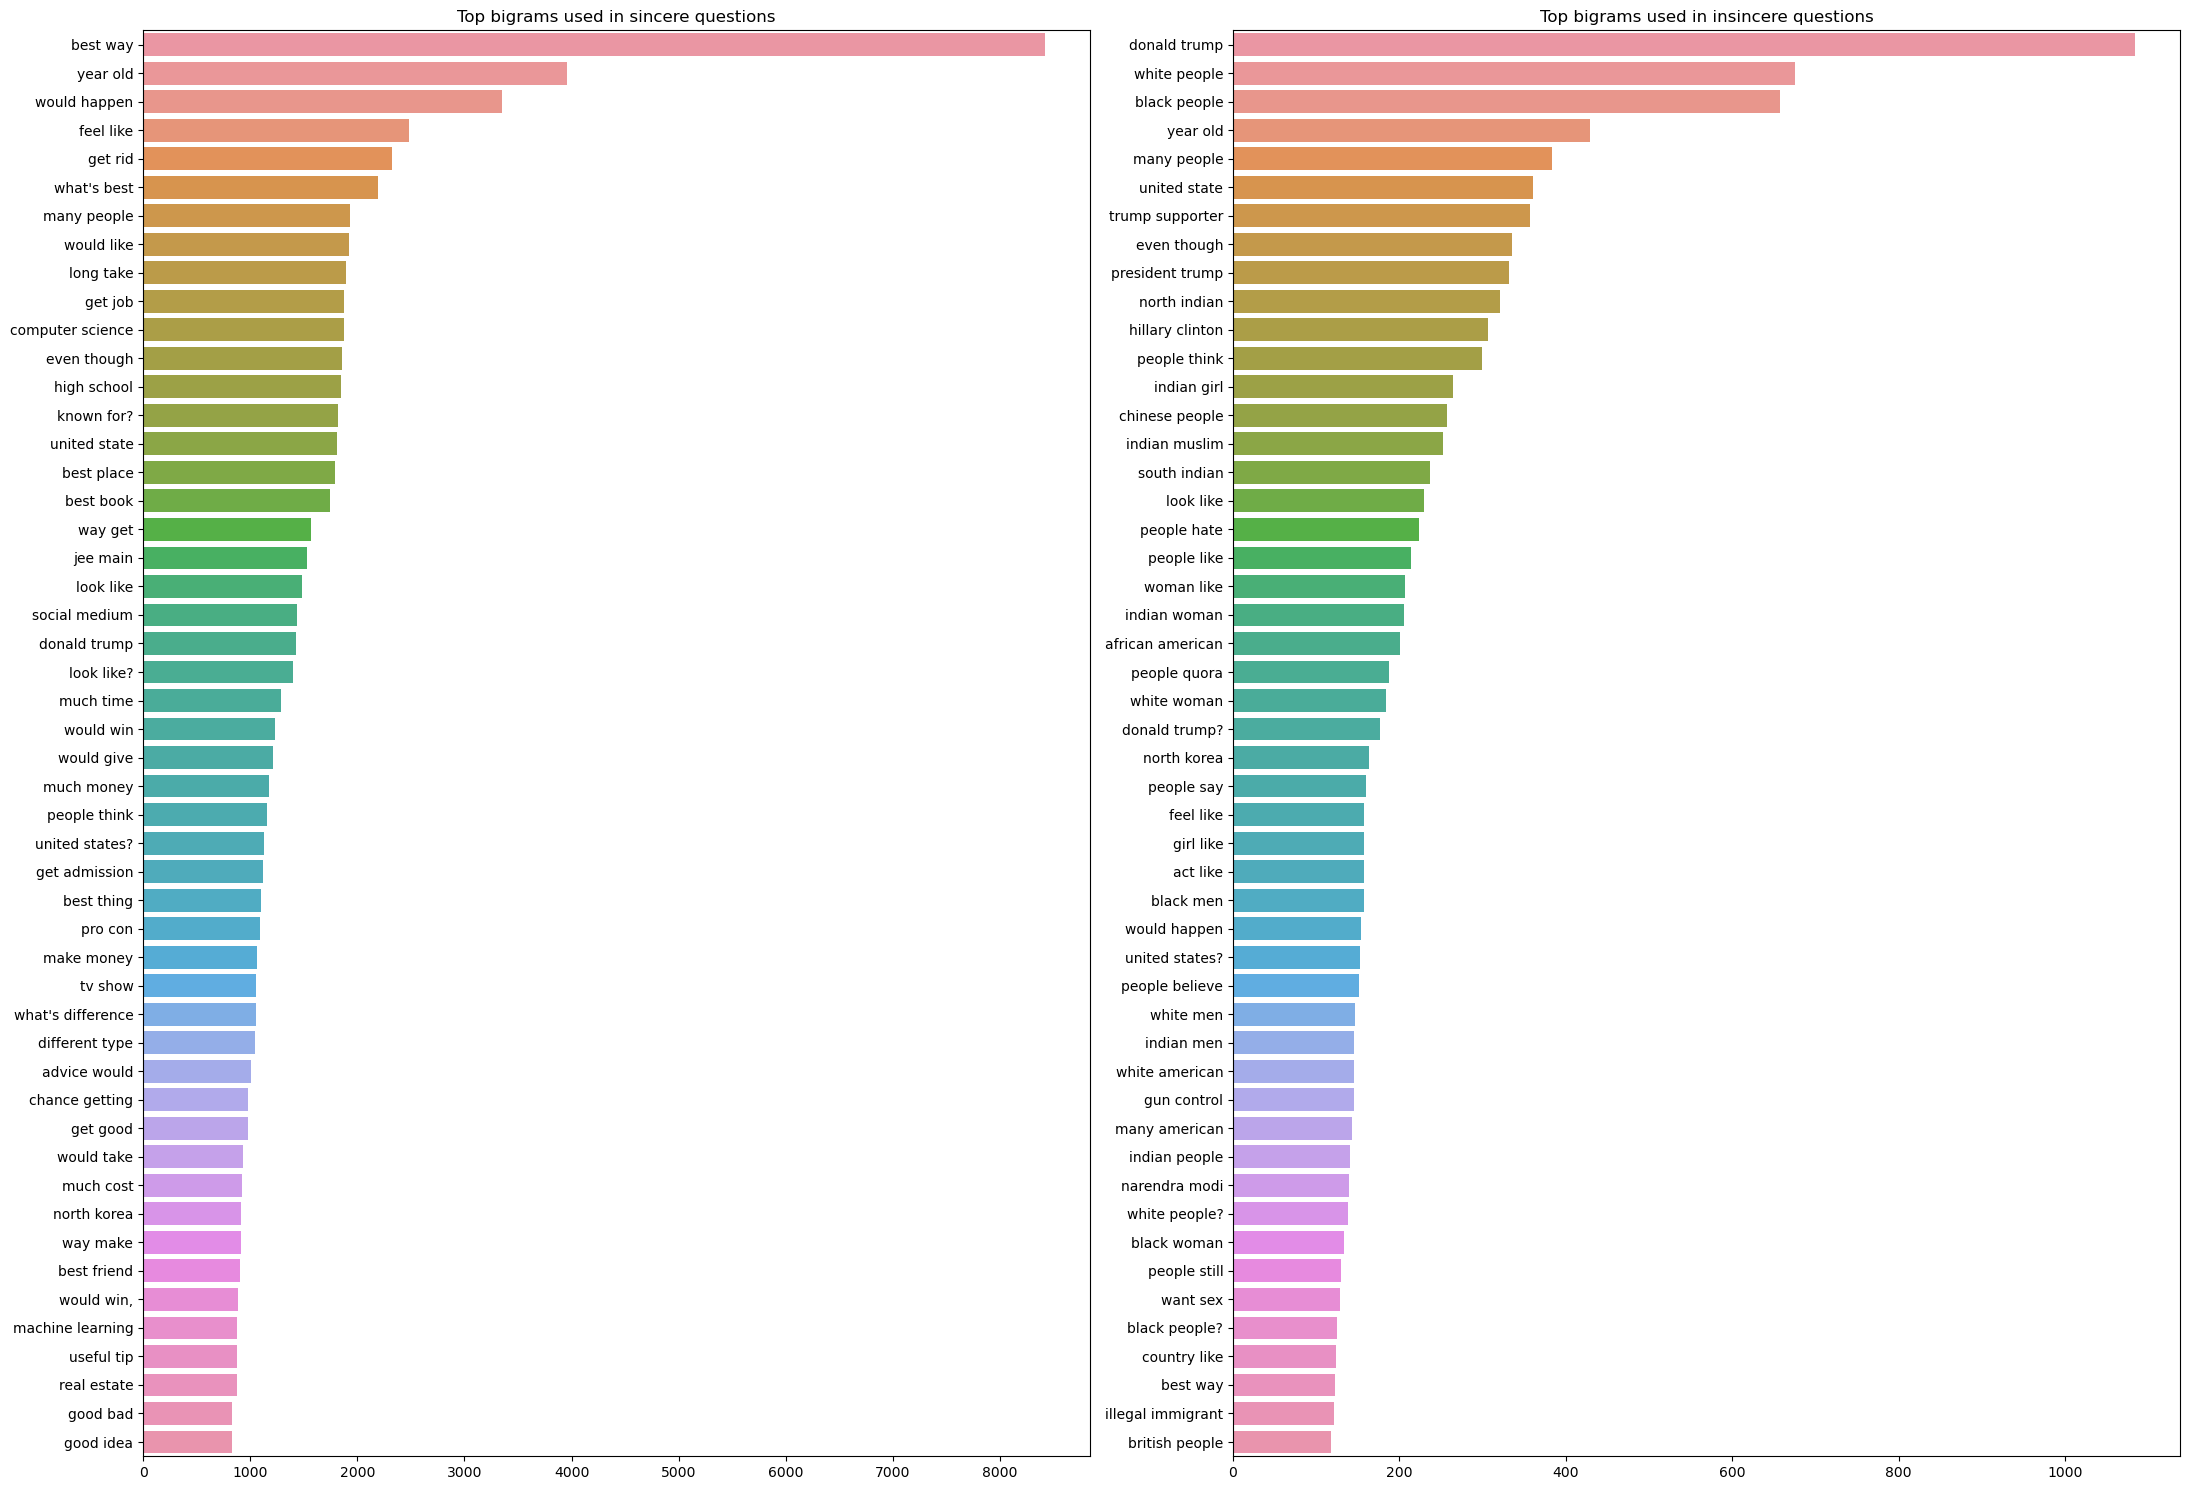

In [166]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22, 15))
plot_top_bigrams(dic_sin_topbigrams, dic_sin_topcountbigrams, "Top bigrams used in sincere questions", ax[0])
plot_top_bigrams(dic_insin_topbigrams, dic_insin_topcountbigrams, "Top bigrams used in insincere questions", ax[1])
plt.tight_layout()
plt.show()

In [168]:
df_sin_para = " ".join([word for word in df_train_sin['question_text']])
df_insin_para = " ".join([word for word in df_train_insin['question_text']])

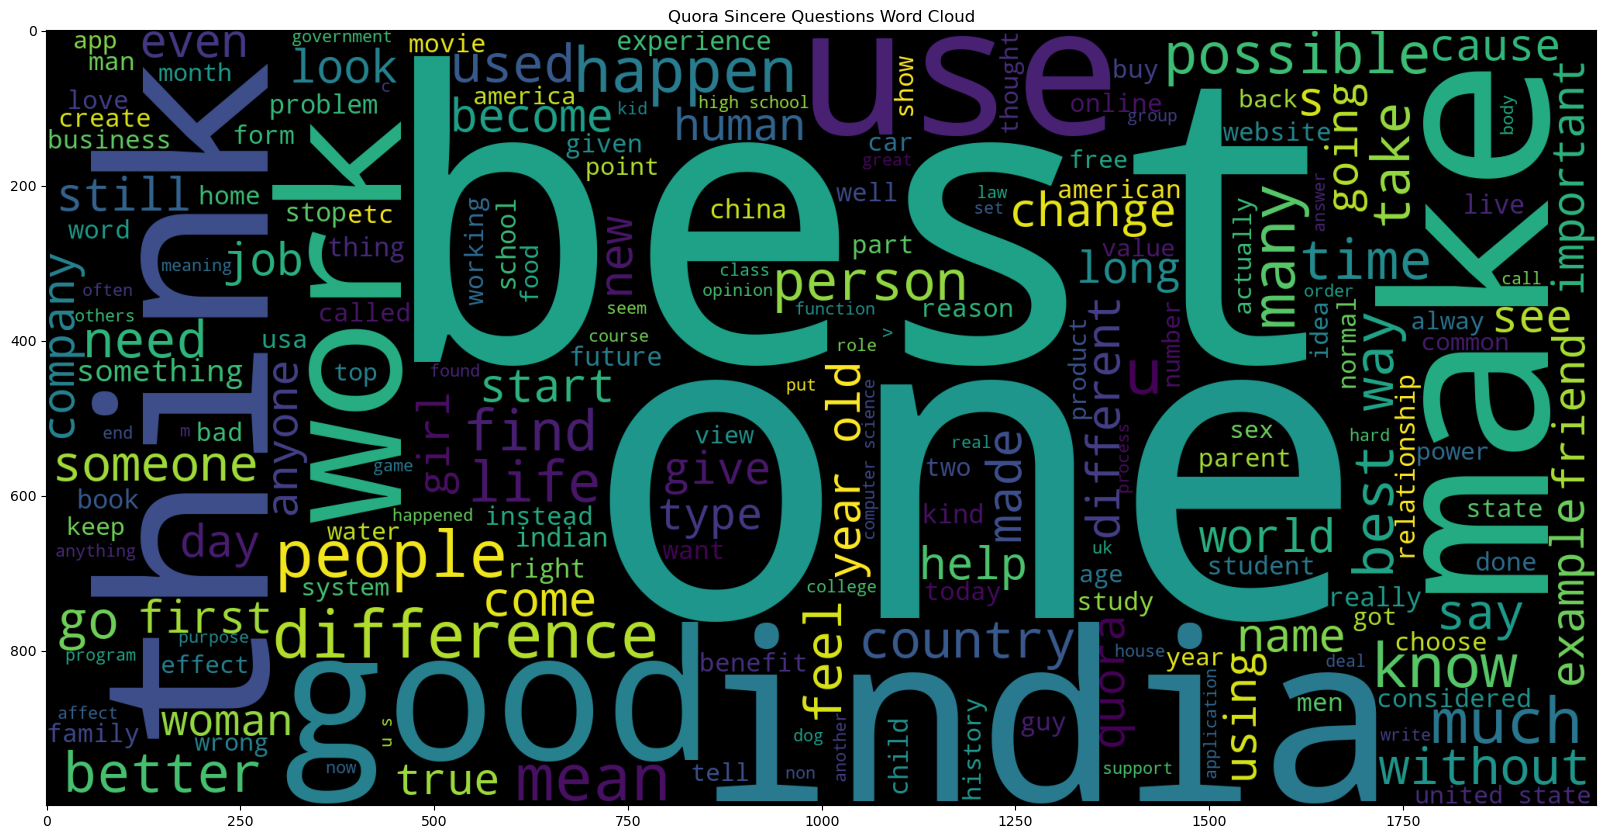

In [170]:
wordcloud=WordCloud(width=2000,height=1000).generate(df_sin_para)

plt.figure(figsize=(20,30))
plt.imshow(wordcloud)
plt.title("Quora Sincere Questions Word Cloud")
plt.show()

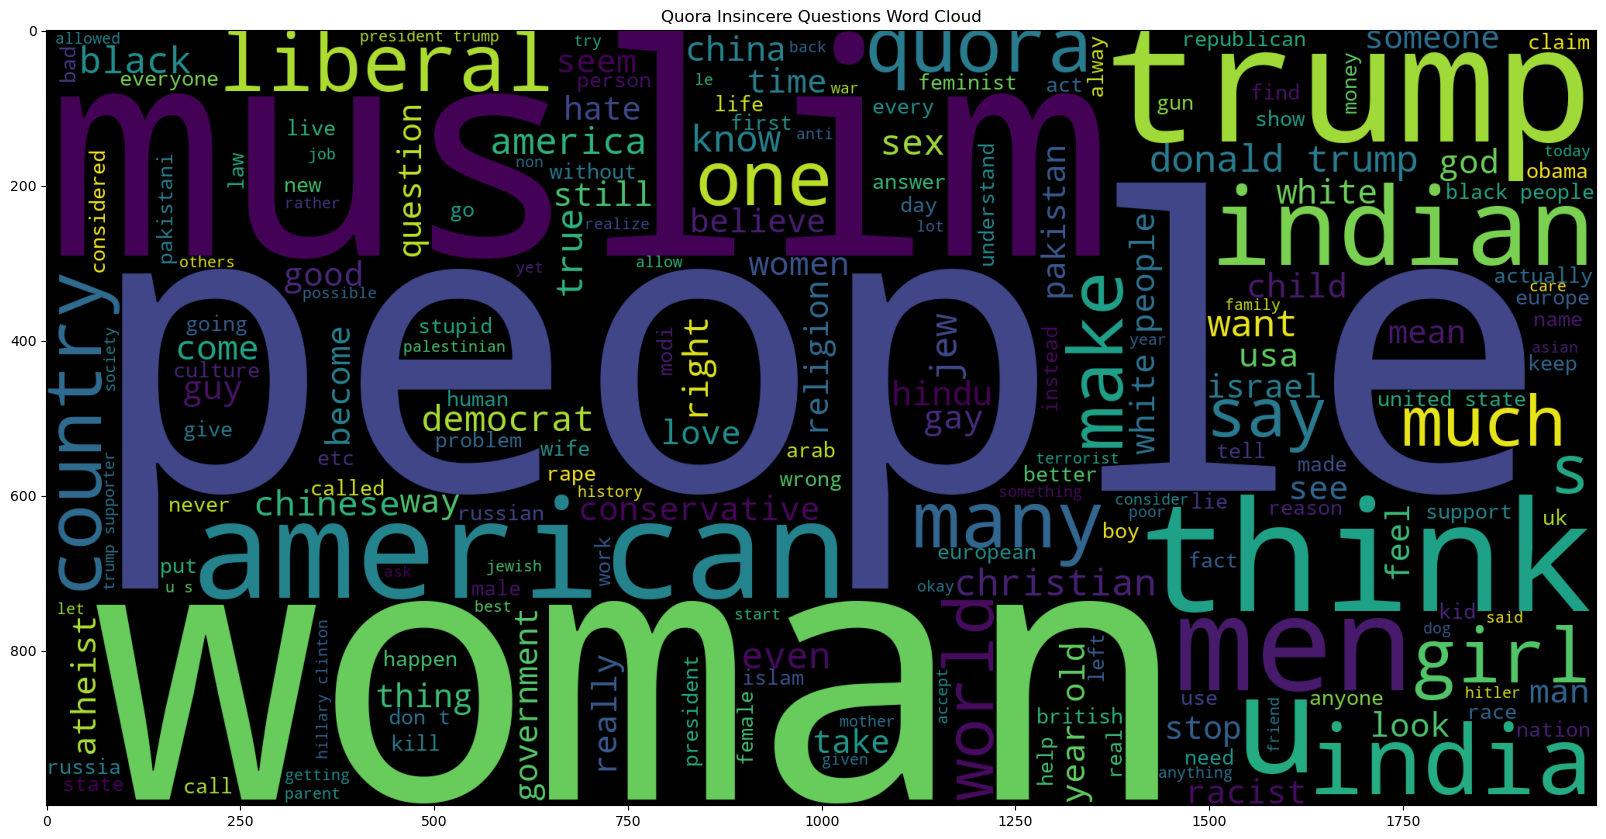

In [172]:
wordcloud=WordCloud(width=2000,height=1000).generate(df_insin_para)

plt.figure(figsize=(20,30))
plt.imshow(wordcloud)
plt.title("Quora Insincere Questions Word Cloud")
plt.show()

# Data Cleaning

In [85]:
# Split the data into train and validation sets
train_data, test_data = train_test_split(data, test_size=validation_split, random_state=42, stratify=data['target'])

In [86]:
def get_emoji_regexp():
    return re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE);

In [87]:
def clean_text(lines):
    all_reviews = list()
    for text in lines:
        text = text.lower()
        
        # Remove URLs
        pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        text = pattern.sub('', text)
        
        # Remove emojis
        text = get_emoji_regexp().sub(r'', text)
        
        # Expanding contractions
        text = contractions.fix(text)
        
        # Remove punctuation
        text = re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]", "", text)

        # Tokenization
        tokens = word_tokenize(text)
        
        # filter out non-alphabetic tokens
        tokens = [word for word in tokens if word.isalpha()]
        
        # Joining words to form the cleaned up text
        cleaned_text = ' '.join(tokens)
        all_reviews.append(cleaned_text)
    return all_reviews

In [88]:
train_data

,question_text,target
240903,Where can I download the PC version of Harry P...,0
587472,Which are the best books for Civil Engineering...,0
1072221,Does Quora forbid answering one's own question...,0
996500,How do I convince my brother to let me worship...,1
407476,What is the best strategy for any consulting c...,0
...,...,...
1283492,What industries will Britain have a comparativ...,0
298451,Who is your favorite Greek philosopher and why?,0
317867,What free software can enable to create PES fi...,0
69923,Why is Islam often confused to be religion of ...,0


In [89]:
train_data.shape

(1240815, 2)

In [90]:
# Clean the train and validation data separately
train_reviews = clean_text(train_data['question_text'])
test_reviews = clean_text(test_data['question_text'])

In [91]:
print(len(train_reviews))
print(len(test_reviews))

1240815
65307


In [92]:
# Tokenize and convert to sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_reviews)  # Fit only on training data
train_sequences = tokenizer.texts_to_sequences(train_reviews)
test_sequences = tokenizer.texts_to_sequences(test_reviews)

In [93]:
word_index = tokenizer.word_index
print("Found %s unique tokens." % len(word_index))

Found 209517 unique tokens.


In [94]:
# Find max length of sequences in train data for padding
max_len = max([len(seq) for seq in train_sequences])

In [95]:
# Pad sequences
x_train = pad_sequences(train_sequences, maxlen=max_len)
x_test = pad_sequences(test_sequences, maxlen=max_len)

In [96]:
# Prepare labels
y_train = to_categorical(np.asarray(train_data['target']))
y_test = to_categorical(np.asarray(test_data['target']))

In [97]:
y_train_binary = y_train[:, 1]  # class "1" is in the second column
y_test_binary = y_test[:, 1]  # class "1" is in the second column

In [98]:
# Now, x_train, y_train, x_val, and y_val are ready for model training
print(f'Train data shape: {x_train.shape}')
print(f'Validation data shape: {x_test.shape}')
print(f'Train labels shape: {y_train.shape}')
print(f'Validation labels shape: {y_test.shape}')

Train data shape: (1240815, 126)
Validation data shape: (65307, 126)
Train labels shape: (1240815, 2)
Validation labels shape: (65307, 2)


In [99]:
x_train[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,    62,    15,     8,   659,     1,  1095,
        1195,     7,  1149,  1667,    11,     1,  8262,  2487,    13,
         191,    11,  3806,  1643,    96,  5927,    25,    40, 10011],
      dtype=int32)

## Reading glove file

In [100]:
# embedding layer
embeddings_index = {}
file = glove_file  # Ensure `glove_file` is defined and points to your GloVe file.
with open(file, encoding='utf8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        except ValueError:
            print(f"Error converting to float for word: {word} - Skipping line")

print(f'Found {len(embeddings_index)} word vectors.')

Error converting to float for word: . - Skipping line
Error converting to float for word: at - Skipping line
Error converting to float for word: . - Skipping line
Error converting to float for word: to - Skipping line
Error converting to float for word: . - Skipping line
Error converting to float for word: . - Skipping line
Error converting to float for word: email - Skipping line
Error converting to float for word: or - Skipping line
Error converting to float for word: contact - Skipping line
Error converting to float for word: Email - Skipping line
Error converting to float for word: on - Skipping line
Error converting to float for word: At - Skipping line
Error converting to float for word: by - Skipping line
Error converting to float for word: in - Skipping line
Error converting to float for word: emailing - Skipping line
Error converting to float for word: Contact - Skipping line
Error converting to float for word: at - Skipping line
Error converting to float for word: • - Skippin

In [101]:
values[0]

'zulchzulu'

In [102]:
word

'zulchzulu'

In [103]:
values[1:]

['-0.07969',
 '-0.22905',
 '0.80366',
 '-0.78865',
 '-0.40567',
 '-0.15716',
 '-0.42302',
 '0.64081',
 '-0.13215',
 '-1.4109',
 '0.73118',
 '-0.37391',
 '-0.36422',
 '0.024199',
 '-0.24359',
 '1.014',
 '0.00065176',
 '-0.89537',
 '0.8054',
 '-0.073101',
 '0.20257',
 '0.59553',
 '-0.0034971',
 '-0.28126',
 '0.58631',
 '-0.17115',
 '0.12428',
 '0.53392',
 '0.48289',
 '0.36989',
 '-0.091151',
 '-0.23874',
 '0.38864',
 '-0.16403',
 '-0.85745',
 '0.19',
 '0.4145',
 '0.35958',
 '-0.018726',
 '0.55213',
 '-0.0091331',
 '-0.48204',
 '-0.64685',
 '0.61736',
 '-0.27128',
 '0.13459',
 '0.94729',
 '-0.42939',
 '-0.32462',
 '-0.088466',
 '0.37337',
 '0.29062',
 '-0.0074411',
 '0.1984',
 '-0.42686',
 '-0.071294',
 '-0.043443',
 '-0.0033026',
 '-0.10519',
 '0.20885',
 '-0.30217',
 '0.27366',
 '-0.35602',
 '-0.89143',
 '0.28561',
 '-0.11656',
 '0.2246',
 '-0.021561',
 '-0.016219',
 '-0.96267',
 '0.85239',
 '-1.2714',
 '-0.8429',
 '0.25947',
 '0.10074',
 '-0.1253',
 '0.016124',
 '0.12488',
 '0.16413',


In [104]:
coefs.shape, coefs

((300,),
 array([-7.9690e-02, -2.2905e-01,  8.0366e-01, -7.8865e-01, -4.0567e-01,
        -1.5716e-01, -4.2302e-01,  6.4081e-01, -1.3215e-01, -1.4109e+00,
         7.3118e-01, -3.7391e-01, -3.6422e-01,  2.4199e-02, -2.4359e-01,
         1.0140e+00,  6.5176e-04, -8.9537e-01,  8.0540e-01, -7.3101e-02,
         2.0257e-01,  5.9553e-01, -3.4971e-03, -2.8126e-01,  5.8631e-01,
        -1.7115e-01,  1.2428e-01,  5.3392e-01,  4.8289e-01,  3.6989e-01,
        -9.1151e-02, -2.3874e-01,  3.8864e-01, -1.6403e-01, -8.5745e-01,
         1.9000e-01,  4.1450e-01,  3.5958e-01, -1.8726e-02,  5.5213e-01,
        -9.1331e-03, -4.8204e-01, -6.4685e-01,  6.1736e-01, -2.7128e-01,
         1.3459e-01,  9.4729e-01, -4.2939e-01, -3.2462e-01, -8.8466e-02,
         3.7337e-01,  2.9062e-01, -7.4411e-03,  1.9840e-01, -4.2686e-01,
        -7.1294e-02, -4.3443e-02, -3.3026e-03, -1.0519e-01,  2.0885e-01,
        -3.0217e-01,  2.7366e-01, -3.5602e-01, -8.9143e-01,  2.8561e-01,
        -1.1656e-01,  2.2460e-01, -2.1561e

## Creating Embedding Matrix

In [106]:
# At this point we can leverage our embedding_index dictionary and our word_index to compute our embedding matrix:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not foud in embedding index will be all zeros.
        embedding_matrix[i] = embedding_vector
    

In [107]:
embedding_matrix.shape

(209518, 300)

## Defining few functions for Modelling

In [108]:
def train_and_evaluate_model(model, model_type, X_train, y_train, X_test, y_test, batch_size=800, epochs=10, class_weight=None):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    callback_list = [
        EarlyStopping(monitor='val_accuracy', patience=5),
        ModelCheckpoint(f'model_{model_type}_{{val_accuracy:.4f}}.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy')
    ]
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, callbacks=callback_list, class_weight=class_weight)
    return history

In [109]:
def plot_metrics(history):
    epochs = len(history.history['loss'])
    plt.figure(figsize=(12, 4))
    for i, metrics in enumerate(zip([history.history['loss'], history.history['accuracy']], 
                                     [history.history['val_loss'], history.history['val_accuracy']], 
                                     ['Loss', 'Accuracy'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()

In [110]:
def select_and_load_best_model(model_type):
    pattern = rf'model_{model_type}_(.*).h5'  # Raw f-string to handle the regular expression
    models = [f for f in os.listdir() if re.match(pattern, f)]
    best_model = max(models, key=lambda x: float(re.findall(rf"model_{model_type}_(.*).h5", x)[0]))
    print(f"Loading best model: {best_model}")
    return load_model(best_model)

In [111]:
def check_cut_off(y_test_binary, pred_probs):
    # Plotting Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test_binary, pred_probs)
    
    plt.figure(figsize=(16, 6))  # Adjust the figure size for both plots to fit
    
    # First plot for Precision-Recall Curve
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
    plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.grid(True)
    plt.legend()
    
    # Calculating metrics for various cutoffs
    cutoff_df = pd.DataFrame(columns=['prob', 'accuracy', 'sensi', 'speci'])
    num = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    
    for i in num:
        preds = (pred_probs > i).astype(int)
        cm1 = confusion_matrix(y_test_binary, preds)
        total1 = sum(sum(cm1))
        accuracy = (cm1[0, 0] + cm1[1, 1]) / total1
        speci = cm1[0, 0] / (cm1[0, 0] + cm1[0, 1])
        sensi = cm1[1, 1] / (cm1[1, 0] + cm1[1, 1])
        cutoff_df.loc[i] = [i, accuracy, sensi, speci]
    
    # Second plot for Accuracy, Sensitivity, and Specificity vs. Probability Thresholds
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
    cutoff_df.plot(x='prob', y=['accuracy', 'sensi', 'speci'], marker='o', ax=plt.gca())
    plt.title('Metrics vs. Probability Thresholds')
    plt.xlabel('Probability Threshold')
    plt.ylabel('Metrics')
    plt.grid(True)
    
    plt.show()

In [112]:
def best_model_stats(y_test_binary, pred_probs, cutoff):
    # Make predictions with the best model
    preds = (pred_probs > cutoff).astype(int).flatten()  # Apply cutoff and flatten to 1D array for binary classification
    print(preds)
    print("\n\n")
    # Print the confusion matrix with a heading
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_binary, preds))

    # Print the classification report with a heading
    print("\nClassification Report:")
    print(classification_report(y_test_binary, preds))

    # Print the accuracy score with a heading
    accuracy = accuracy_score(y_test_binary, preds)
    print(f"Accuracy Score: {accuracy:.4f}")

    # Print the ROC AUC score with a heading
    roc_auc = roc_auc_score(y_test_binary, pred_probs)
    print(f"ROC AUC Score: {roc_auc:.4f}") # Use pred_probs here for AUC since it expects probabilities

    average_precision = average_precision_score(y_test_binary, pred_probs)
    print(f"Average Precision: {average_precision:.4f}")

    balanced_accuracy = balanced_accuracy_score(y_test_binary, preds)
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")

    kappa = cohen_kappa_score(y_test_binary, preds)
    print(f"Cohen’s Kappa: {kappa:.4f}")

    loss = log_loss(y_test_binary, pred_probs)
    print(f"Log Loss: {loss:.4f}")

    mcc = matthews_corrcoef(y_test_binary, preds)
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")
    

## Model Building

In [113]:
embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim,
                           weights = [embedding_matrix],
                           input_length = max_len,
                           trainable = False)                     

### Model 1

In [114]:
# finally we can then buid a small 1D convenet to solve our classification problem:
sequence_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = GRU(128, return_sequences=True)(embedded_sequences)  # return_sequences=True if you add more GRU layers after this
x = Dropout(0.2)(x)  # Adding dropout layer
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)  # Adding dropout layer
x = GRU(64)(x)  # Last GRU layer does not return sequences
x = Dropout(0.2)(x)  # Adding dropout layer
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(sequence_input, outputs)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 126)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 126, 300)          62855400  
                                                                 
 gru_5 (GRU)                 (None, 126, 128)          165120    
                                                                 
 dropout_10 (Dropout)        (None, 126, 128)          0         
                                                                 
 dense_9 (Dense)             (None, 126, 128)          16512     
                                                                 
 dropout_11 (Dropout)        (None, 126, 128)          0         
                                                                 
 gru_6 (GRU)                 (None, 64)                3724

In [115]:
model_type = "model_1"
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
model_type = f"{model_type}_{timestamp}"
history = train_and_evaluate_model(model, model_type, x_train, y_train_binary, x_test, y_test_binary, batch_size=128, epochs=10, class_weight={0:1,1:8})

Epoch 1/10


2024-03-06 00:09:11.648176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-06 00:09:12.042558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-06 00:09:12.236439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-06 00:09:12.594414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


   1/9694 [..............................] - ETA: 6:03:08 - loss: 0.9755 - accuracy: 0.7891

2024-03-06 00:09:12.820981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9694/9694 [==============================] - ETA: 0s - loss: 0.3792 - accuracy: 0.9123

2024-03-06 00:15:49.180954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-06 00:15:49.281545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-06 00:15:49.383666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9694/9694 [==============================] - 411s 42ms/step - loss: 0.3792 - accuracy: 0.9123 - val_loss: 0.1882 - val_accuracy: 0.9225
Epoch 2/10
9694/9694 [==============================] - 403s 42ms/step - loss: 0.3343 - accuracy: 0.9237 - val_loss: 0.2276 - val_accuracy: 0.9040
Epoch 3/10
9694/9694 [==============================] - 406s 42ms/step - loss: 0.3233 - accuracy: 0.9258 - val_loss: 0.1750 - val_accuracy: 0.9288
Epoch 4/10
9694/9694 [==============================] - 404s 42ms/step - loss: 0.3081 - accuracy: 0.9286 - val_loss: 0.1791 - val_accuracy: 0.9241
Epoch 5/10
9694/9694 [==============================] - 403s 42ms/step - loss: 0.3039 - accuracy: 0.9303 - val_loss: 0.1813 - val_accuracy: 0.9223
Epoch 6/10
9694/9694 [==============================] - 401s 41ms/step - loss: 0.3175 - accuracy: 0.9286 - val_loss: 0.1793 - val_accuracy: 0.9253
Epoch 7/10
9694/9694 [==============================] - 402s 41ms/step - loss: 0.3392 - accuracy: 0.9254 - val_loss: 0.2186 - val

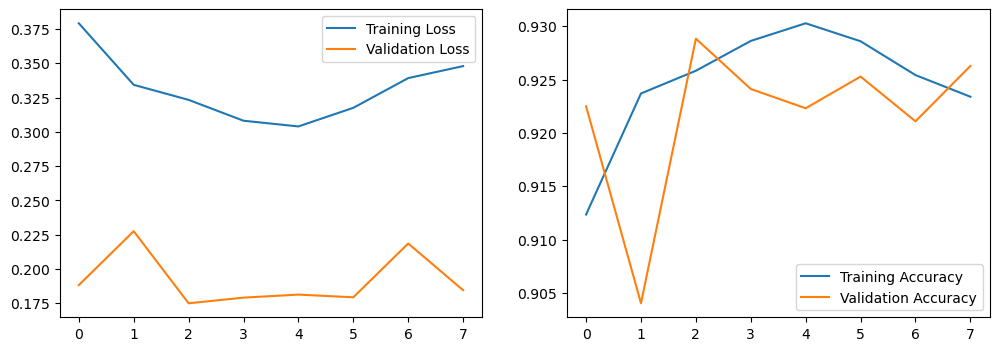

In [120]:
plot_metrics(history)

In [121]:
# Automatically select and load the best model
best_model_1 = select_and_load_best_model(model_type)

Loading best model: model_model_1_2024-03-06_00-09-10_0.9288.h5


In [122]:
pred_probs = best_model_1.predict(x_test)
print(pred_probs)

2024-03-06 01:13:09.024380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-06 01:13:09.118801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


   2/2041 [..............................] - ETA: 3:11 

2024-03-06 01:13:09.250786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2041/2041 [==============================] - 37s 18ms/step
[[0.08428035]
 [0.7893572 ]
 [0.13088997]
 ...
 [0.01250448]
 [0.04083081]
 [0.0078363 ]]


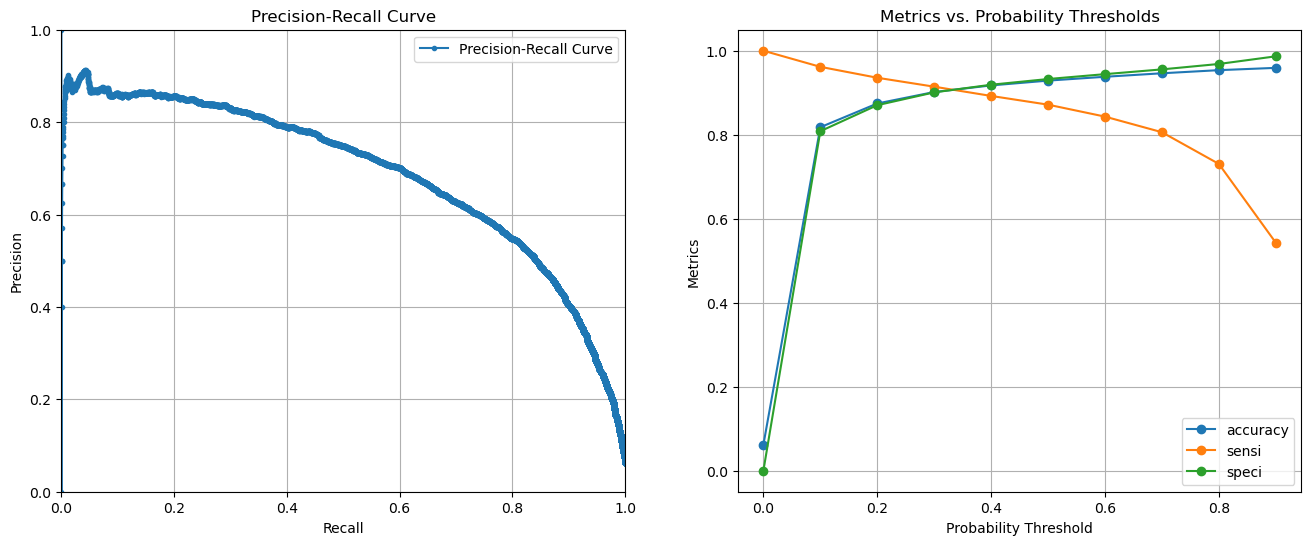

In [123]:
check_cut_off(y_test_binary=y_test_binary, pred_probs=pred_probs)

In [124]:
best_model_stats(y_test_binary=y_test_binary, cutoff=0.3, pred_probs=pred_probs)

[0 1 0 ... 0 0 0]



Confusion Matrix:
[[55190  6076]
 [  346  3695]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.90      0.95     61266
         1.0       0.38      0.91      0.54      4041

    accuracy                           0.90     65307
   macro avg       0.69      0.91      0.74     65307
weighted avg       0.96      0.90      0.92     65307

Accuracy Score: 0.9017
ROC AUC Score: 0.9634
Average Precision: 0.6889
Balanced Accuracy: 0.9076
Cohen’s Kappa: 0.4904
Log Loss: 0.1750
Matthews Correlation Coefficient: 0.5506


### Model 2

In [50]:
# Convolutional layer to extract local features
x = Conv1D(filters=128, kernel_size=5, activation='relu')(embedded_sequences)
x = Dropout(0.2)(x)  # Adding dropout for regularization

# Assuming you want to use GRU to further process the sequence
# Ensure GRU is set to return sequences if you plan to use GlobalMaxPooling1D afterwards
x = GRU(128, return_sequences=True)(x)
x = Dropout(0.2)(x)  # Adding dropout for regularization

# Correctly applying GlobalMaxPooling1D after GRU
x = GlobalMaxPooling1D()(x)  # Summarize sequence information

# Dense layer with Batch Normalization before activation
x = Dense(128)(x)  # Not applying activation here
x = BatchNormalization()(x)  # Batch Normalization layer
x = Activation('relu')(x)  # Activation layer added after Batch Normalization
x = Dropout(0.2)(x)  # Adding dropout for regularization

# Output layer
outputs = Dense(1, activation='sigmoid')(x)

# Creating the model
model = Model(inputs=sequence_input, outputs=outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 126)]             0         
                                                                 
 embedding (Embedding)       (None, 126, 300)          62855400  
                                                                 
 conv1d (Conv1D)             (None, 122, 128)          192128    
                                                                 
 dropout_3 (Dropout)         (None, 122, 128)          0         
                                                                 
 gru_2 (GRU)                 (None, 122, 128)          99072     
                                                                 
 dropout_4 (Dropout)         (None, 122, 128)          0         
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0   

In [51]:
model_type = "model_2"
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
model_type = f"{model_type}_{timestamp}"
history = train_and_evaluate_model(model, model_type, x_train, y_train_binary, x_test, y_test_binary, batch_size=128, epochs=10, class_weight={0:1,1:8})

Epoch 1/10


2024-03-05 11:38:34.930084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-05 11:38:35.155748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


   1/9694 [..............................] - ETA: 3:20:43 - loss: 0.9070 - accuracy: 0.5078

2024-03-05 11:38:35.534892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9694/9694 [==============================] - ETA: 0s - loss: 0.3989 - accuracy: 0.9063

2024-03-05 11:45:50.312087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-05 11:45:50.396926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9694/9694 [==============================] - 446s 46ms/step - loss: 0.3989 - accuracy: 0.9063 - val_loss: 0.1519 - val_accuracy: 0.9410
Epoch 2/10
9694/9694 [==============================] - 445s 46ms/step - loss: 0.3560 - accuracy: 0.9177 - val_loss: 0.1785 - val_accuracy: 0.9305
Epoch 3/10
9694/9694 [==============================] - 445s 46ms/step - loss: 0.3368 - accuracy: 0.9213 - val_loss: 0.1729 - val_accuracy: 0.9321
Epoch 4/10
9694/9694 [==============================] - 446s 46ms/step - loss: 0.3241 - accuracy: 0.9235 - val_loss: 0.1580 - val_accuracy: 0.9345
Epoch 5/10
9694/9694 [==============================] - 448s 46ms/step - loss: 0.3144 - accuracy: 0.9246 - val_loss: 0.1917 - val_accuracy: 0.9229
Epoch 6/10
9694/9694 [==============================] - 448s 46ms/step - loss: 0.3055 - accuracy: 0.9253 - val_loss: 0.2039 - val_accuracy: 0.9189


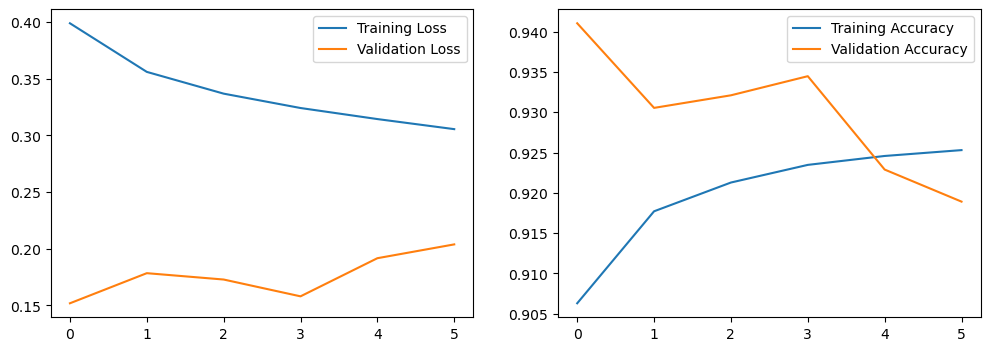

In [52]:
plot_metrics(history)

In [53]:
# Automatically select and load the best model
best_model_2 = select_and_load_best_model(model_type)

Loading best model: model_model_2_2024-03-05_11-38-34_0.9410.h5


In [54]:
pred_probs_2 = best_model_2.predict(x_test)
print(pred_probs_2)

   1/2041 [..............................] - ETA: 9:26

2024-03-05 12:23:14.089542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-05 12:23:14.165120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2041/2041 [==============================] - 17s 8ms/step
[[0.28169665]
 [0.79081273]
 [0.27574727]
 ...
 [0.01000772]
 [0.07484983]
 [0.00815263]]


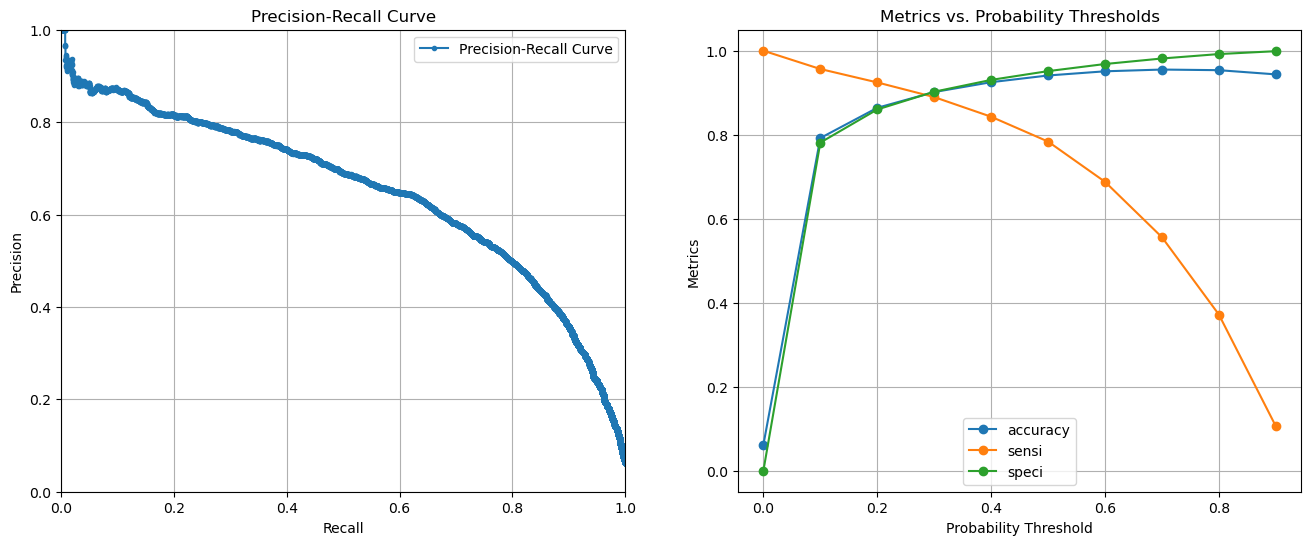

In [55]:
check_cut_off(y_test_binary=y_test_binary, pred_probs=pred_probs_2)

In [58]:
best_model_stats(y_test_binary=y_test_binary, cutoff=0.3, pred_probs=pred_probs_2)

[0 1 0 ... 0 0 0]



Confusion Matrix:
[[58290  2976]
 [  874  3167]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97     61266
         1.0       0.52      0.78      0.62      4041

    accuracy                           0.94     65307
   macro avg       0.75      0.87      0.79     65307
weighted avg       0.96      0.94      0.95     65307

Accuracy Score: 0.9410
ROC AUC Score: 0.9548
Average Precision: 0.6501
Balanced Accuracy: 0.8676
Cohen’s Kappa: 0.5915
Log Loss: 0.1519
Matthews Correlation Coefficient: 0.6067


### Model 3

In [61]:
# Convolutional layer to extract local features
x = Conv1D(filters=128, kernel_size=5, activation='relu')(embedded_sequences)
x = Dropout(0.2)(x)  # Adding dropout for regularization

# Assuming you want to use GRU to further process the sequence
# Ensure GRU is set to return sequences if you plan to use GlobalMaxPooling1D afterwards
x = Bidirectional(GRU(128, return_sequences=True))(x)
x = Dropout(0.2)(x)  # Adding dropout for regularization

# Correctly applying GlobalMaxPooling1D after GRU
x = GlobalMaxPooling1D()(x)  # Summarize sequence information

# Dense layer with Batch Normalization before activation
x = Dense(128)(x)  # Not applying activation here
x = BatchNormalization()(x)  # Batch Normalization layer
x = Activation('relu')(x)  # Activation layer added after Batch Normalization
x = Dropout(0.2)(x)  # Adding dropout for regularization

# Output layer
outputs = Dense(1, activation='sigmoid')(x)

# Creating the model
model = Model(inputs=sequence_input, outputs=outputs)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 126)]             0         
                                                                 
 embedding (Embedding)       (None, 126, 300)          62855400  
                                                                 
 conv1d_2 (Conv1D)           (None, 122, 128)          192128    
                                                                 
 dropout_7 (Dropout)         (None, 122, 128)          0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 122, 256)          198144    
 onal)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 122, 256)          0         
                                                           

In [62]:
model_type = "model_3"
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
model_type = f"{model_type}_{timestamp}"
history = train_and_evaluate_model(model, model_type, x_train, y_train_binary, x_test, y_test_binary, batch_size=128, epochs=30, class_weight={0:1,1:8})

Epoch 1/30


2024-03-05 16:40:12.259692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-05 16:40:12.571581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-05 16:40:12.628325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-05 16:40:13.125341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-05 16:40:13.147560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9694/9694 [==============================] - ETA: 0s - loss: 0.3883 - accuracy: 0.9086

2024-03-05 16:52:26.158352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-05 16:52:26.275936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-05 16:52:26.287897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9694/9694 [==============================] - 750s 77ms/step - loss: 0.3883 - accuracy: 0.9086 - val_loss: 0.2026 - val_accuracy: 0.9289
Epoch 2/30
9694/9694 [==============================] - 746s 77ms/step - loss: 0.3451 - accuracy: 0.9205 - val_loss: 0.1909 - val_accuracy: 0.9270
Epoch 3/30
9694/9694 [==============================] - 745s 77ms/step - loss: 0.3259 - accuracy: 0.9239 - val_loss: 0.1855 - val_accuracy: 0.9439
Epoch 4/30
9694/9694 [==============================] - 747s 77ms/step - loss: 0.3124 - accuracy: 0.9256 - val_loss: 0.1535 - val_accuracy: 0.9444
Epoch 5/30
9694/9694 [==============================] - 747s 77ms/step - loss: 0.3016 - accuracy: 0.9273 - val_loss: 0.1395 - val_accuracy: 0.9448
Epoch 6/30
9694/9694 [==============================] - 748s 77ms/step - loss: 0.2924 - accuracy: 0.9278 - val_loss: 0.1657 - val_accuracy: 0.9347
Epoch 7/30
9694/9694 [==============================] - 746s 77ms/step - loss: 0.2856 - accuracy: 0.9288 - val_loss: 0.1597 - val

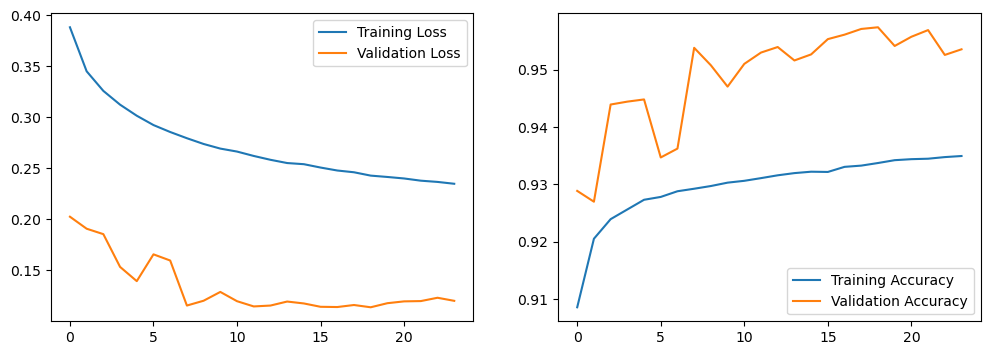

In [63]:
plot_metrics(history)

In [64]:
# Automatically select and load the best model
best_model_3 = select_and_load_best_model(model_type)

Loading best model: model_model_3_2024-03-05_16-40-11_0.9574.h5


In [65]:
pred_probs_3 = best_model_2.predict(x_test)
print(pred_probs_3)

2041/2041 [==============================] - 39s 19ms/step
[[0.25353009]
 [0.9002618 ]
 [0.00329166]
 ...
 [0.0359403 ]
 [0.07736503]
 [0.01437575]]


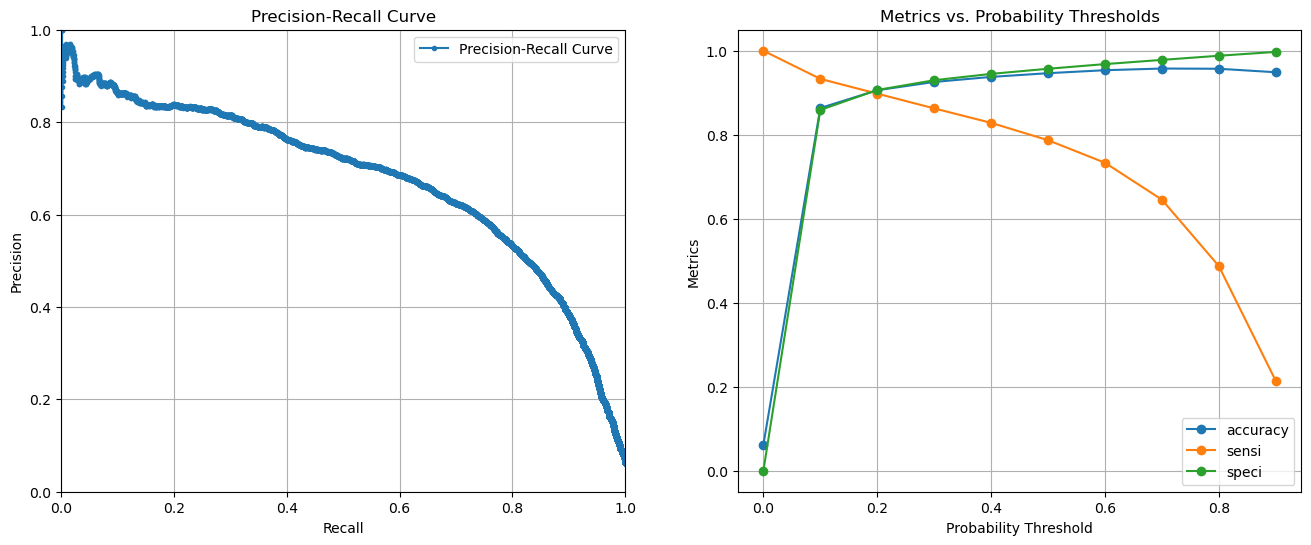

In [66]:
check_cut_off(y_test_binary=y_test_binary, pred_probs=pred_probs_3)

In [70]:
best_model_stats(y_test_binary=y_test_binary, cutoff=0.2, pred_probs=pred_probs_3)

[1 1 0 ... 0 0 0]



Confusion Matrix:
[[55537  5729]
 [  413  3628]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.91      0.95     61266
         1.0       0.39      0.90      0.54      4041

    accuracy                           0.91     65307
   macro avg       0.69      0.90      0.74     65307
weighted avg       0.96      0.91      0.92     65307

Accuracy Score: 0.9060
ROC AUC Score: 0.9568
Average Precision: 0.6757
Balanced Accuracy: 0.9021
Cohen’s Kappa: 0.4982
Log Loss: 0.1305
Matthews Correlation Coefficient: 0.5531


# Conclusion

- Our dataset for predicting spam/ham is significantly skewed.
- We conducted Exploratory Data Analysis (EDA), and visualized data using word clouds, and plots for unigrams and bigrams.
- For the modeling task, we employed GloVe for text embedding.
- We generated an embedding matrix using GloVe for all text entries in the dataset.
- We developed two models using Gated Recurrent Units (GRU) and one model using a Bidirectional GRU. Given the dataset's severe imbalance, we applied class weights during modeling.
- We achieved an accuracy between 90% to 94%. However, given the dominance of the negative class at 94%, such high accuracy is expected.
- To further assess model performance, we examined various metrics including the confusion matrix, ROC AUC Score, Average Precision, Balanced Accuracy, Cohen’s Kappa, Log Loss, and  Matthews Correlation Coefficient. The precision and recall rates for both classes are reasonably high. Yet, the precision for class 1 requires enhancement, indicating substantial scope for improvement.